# Parking Simulator

In [1]:
import simpy
import random

RANDOM_SEED = 42
SIM_TIME = 24 * 60

MAX_CAPACITY = 1

MIN_CAR_PARK_TIME = 10
MAX_CAR_PARK_TIME = 120

MIN_FINDING_SPOT = 1
MAX_FINDING_SPOT = 10
EXITING_TIME = 4

In [2]:
def nrml_dist(min_, max_):
    mu = (max_ + min_) / 2
    sigma = mu / 3
    
    rd_numb = random.normalvariate(mu, sigma)
    
    if (rd_numb < min_):
        rd_numb = min_
    if (rd_numb > max_):
        rd_numb = max_
    
    return round(rd_numb)

# for i in range(50):
#     print(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

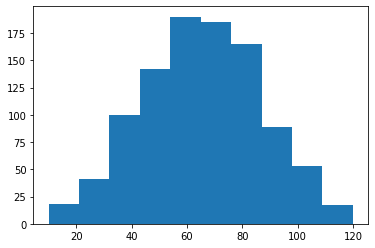

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
park_times = []

for i in range(1000):
    park_times.append(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))

park_times.sort()
plt.hist(park_times)
plt.show()

In [4]:
class Garage(object):
    def __init__(self, env, max_spots=MAX_CAPACITY):
        self.env = env
        self.spots = simpy.Resource(env, max_spots)

In [5]:
def car(env, name, garage):
        
    # Request one of its charging spots
    print('%s arriving at %d' % (name, env.now))
    with garage.spots.request() as req:
        yield req
        # Find spot
        print('%s finding parking spot %s' % (name, env.now))
        yield env.timeout(nrml_dist(MIN_FINDING_SPOT, MAX_FINDING_SPOT))

        # Park car
        print('%s starting to park %s' % (name, env.now))
        yield env.timeout(nrml_dist(MIN_CAR_PARK_TIME, MAX_CAR_PARK_TIME))
        print('%s leaving the parking spot %s' % (name, env.now))
        
        # Leaving garage
        print('%s starting to leave %s' % (name, env.now))
        yield env.timeout(EXITING_TIME)
        print('%s left %s' % (name, env.now))
        

In [6]:
def main():
    random.seed(RANDOM_SEED)
    
    env = simpy.Environment()
    
    garage = Garage(env)
    
    for i in range(0, 5):
        env.process(car(env, i, garage))

    env.run(until=SIM_TIME)


main()

0 arriving at 0
1 arriving at 0
2 arriving at 0
3 arriving at 0
4 arriving at 0
0 finding parking spot 0
0 starting to park 6
0 leaving the parking spot 60
0 starting to leave 60
0 left 64
1 finding parking spot 64
1 starting to park 72
1 leaving the parking spot 134
1 starting to leave 134
1 left 138
2 finding parking spot 138
2 starting to park 142
2 leaving the parking spot 219
2 starting to leave 219
2 left 223
3 finding parking spot 223
3 starting to park 226
3 leaving the parking spot 329
3 starting to leave 329
3 left 333
4 finding parking spot 333
4 starting to park 338
4 leaving the parking spot 429
4 starting to leave 429
4 left 433
